<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-network" data-toc-modified-id="Load-network-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Load network</a></span></li><li><span><a href="#Load-cases" data-toc-modified-id="Load-cases-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Load cases</a></span></li></ul></li></ul></li></ul></div>

# Learning Generation - Part 2

Now let's reincorporate line capacity constraints.

In [1]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Distributions, Random
using LinearAlgebra
using Plots

using Revise
using CarbonNetworks

# Load data

### Load network

In [2]:
DATAPATH = "/Users/degleris/Data/carbon_networks/"
A, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH; num_generators=1)
n = length(gmax)
m = length(pmax)

# Remove infinite capacities
pmax[pmax .== Inf] .= 1.1 * maximum(gmax)

normalization = mean(gmax)
gmax /= normalization
pmax /= normalization

@show n, m;

agg_nodes, B = create_generation_map(nodes);

(n, m) = (380, 471)


### Load cases

In [3]:
file_names = joinpath.(joinpath(DATAPATH, "TRAIN"), readdir(joinpath(DATAPATH, "TRAIN")))

cases = []
for file in file_names   
    d, g, case = load_case(file, agg_nodes, B, nodes)
    d = d/normalization
    g = g/normalization
    push!(cases, (d=d, g=g, case=case))
end

train_size = 1
test_size = 1

train_cases = cases[1:train_size]
test_cases = cases[100:100];

# Initialize

In [4]:
# Seeds that seem to work: 706
seed = rand(1:1_000)
Random.seed!(seed)
@show seed

# Initialize estimated costs
f̂ = max.(1.0, 10 .+ randn(n)) 
@show norm(f̂)

train_loss_hist = []
test_loss_hist = []
grad_hist = []

seed = 725
norm(f̂) = 196.84194758728336


Any[]

# Fit

In [5]:
# Algorithm parameters
step_size = 10.0
max_iter = 1_000
batch_size = 1
test_batch_size = 1

1

In [6]:
@time for iter in 1:max_iter
    if mod(iter, 50) == 0
        print("$(iter)-")
    end
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, df = stochastic_loss_and_grad(f̂, B, train_cases, pmax, gmax, A, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, df)
    
    # Compute test loss
    # sample = rand(1:length(test_cases), test_batch_size)
    # L_test, _ = stochastic_loss_and_grad(f̂, B, test_cases, pmax, gmax, A, sample)
    # push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    # df += (1/n) * f̂
    η = 0.01 * min(norm(df), step_size)
    f̂ = max.(f̂ - η*(df/norm(df)), 0)
end

@show norm(f̂)
@show minimum(train_loss_hist)
println("Completed $(max_iter) iterations.")

50-100-150-200-250-300-350-400-450-500-550-600-650-700-750-800-850-900-950-1000- 88.885967 seconds (115.10 M allocations: 25.440 GiB, 3.81% gc time, 0.02% compilation time)
norm(f̂) = 197.1164813527473
minimum(train_loss_hist) = 1.2547576747215514
Completed 1000 iterations.


minimum(norm.(grad_hist)) = 6.194362074151956


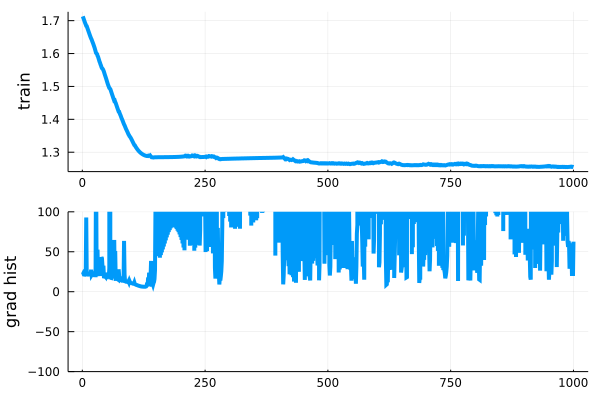

In [34]:
theme(:default, lw=4, label=nothing)

@show minimum(norm.(grad_hist))

Δhist = [df[100] for df in grad_hist]
Δhist = norm.(grad_hist)

plot(
    plot(train_loss_hist, ylabel="train"),
    plot(Δhist, ylabel="grad hist", ylim=(-100, 100)),
    layout=(2, 1)
)

┌ Info: Saved animation to 
│   fn = /Users/degleris/Documents/Research/CarbonNetworks/notebooks/tmp.gif
└ @ Plots /Users/degleris/.julia/packages/Plots/vVVub/src/animation.jl:104


Plots.AnimatedGif("/Users/degleris/Documents/Research/CarbonNetworks/notebooks/tmp.gif")
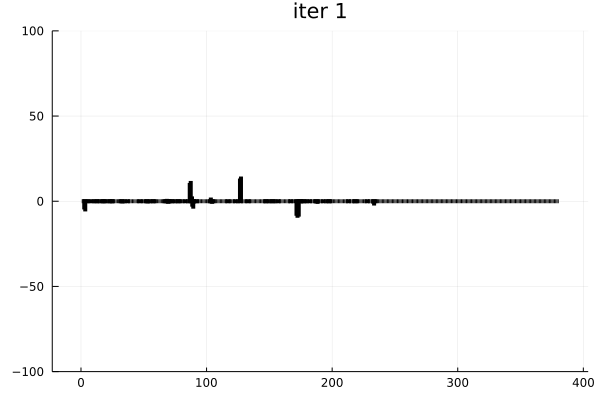

In [33]:
@gif for iter in 1:500
    iter = ceil(Int, iter / 5)
    bar(grad_hist[iter], ylim=(-100, 100), title="iter $iter")
end